# Business Case Analysis: Unsupervised Learning

In this business case analysis I am using an online retail store dataset found in the [Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Online+Retail). The aim of this dataset is to identify models of purchases across the time. I will perform in this dataset:
- Artificial intelligence and natural language processing to identify category concepts given descriptions. Meaning identify the overall concept of a description given its content.
- Apply unsuperviser Learning to find groups of purchases.
- Apply ARIMA model to predict sells in a given period of time. 

In [1]:
import pandas as pd
from pandas import ExcelFile
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sys
from pandas.plotting import autocorrelation_plot
import warnings
import statsmodels.api as sm

In [2]:
data_original = pd.read_excel('Online Retail.xlsx')

# Overall purchasing analysis

The original dataset does not contain the total amount spent per purchase. Thus, I will add an extra column to compute the total amount of money spent per transaction. This is an overall purchasing analysis.

In [3]:
TotalPrice = data_original['Quantity']*data_original['UnitPrice']
dfTotal = pd.DataFrame(TotalPrice, columns = ['TotalPrice'])
data_original = pd.concat([data_original,dfTotal], axis=1)

In [4]:
data_original

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08


# Apply Natural Language Processing

Now I will apply nlp to identify categories for each of the purchased items. The aim with this analysis is to identify to which categorie does the description might be. Clothes, Personal Accessories, Home Accesories. For this purpose, I will build a semantic group of words related to clothes, Personal Accessories and Home Accesories, given visual inspection of descriptions. 

In [5]:
# set of words for each of the special categories, manually created. Get synonims of those words.
clothes = ['hat','warmer','hairband','hand','spinning','tops','jacket', 'coat', 'fashion', '', 'jeans', 'pullover', 'warmer','socks', 'shirt', 'gloves', 'shoes','underware', 'bra','panties','boxer', 'blazer', 'pijama', 'pants', 'hoodie']
personal_accessories = ['plasters','slate','stickers','feltcraft','tag','luggage','flag','paint','invites','paper','pen', 'wrap','cases','cones','candleholder','magnets','notebook','treasure','disco','incense','balloons','picture','cones','skulls','soldier','rope','kit','umbrella','clock','magnets','flower','ducks','thermometer','calculator','discount','globe','toy','retrospot','photo','shopper','tool','pc','bag','mugs','parasol','postage','jigsaw','puzzles','game','globe','tape','watch', 'ring', 'parade', 'strongman', 'plaster', 'beak','lipstick', 'sticker', 'ornament', 'apron', 'plasters','earrings', 'bracelet', 'necklace', 'hair', 'piercing']
home = ['jug','coasters','christmas','ribbons','parcel','craft','bell','woodland','candleholder','cutter','cushion','bucket','sponge','paper','lights','candles','tube','quilt','mirror','sign','placemats','bottle','doorstop','organiser','spoons','ribbons','chalkboard','wicker','board','baskets','table','ladders','box','hook','candle','bank', 'beakers', 'parasol','tea','chain','cup','coaster','knob','sign', 'doorsign','bin','plates','cabinet','frame','picture','woolly','towels','babushka','doormat','school','boxes', 'holder','building', 'home', 'block', 'blocks','sheet', 'bedroom', 'wool','kitchen', 't-light','light','lantern','napkins', 'bowl', 'scissor', 'bottle', 'cake', 'making', 'doll', 'doormat' 'block', 'mat', 'cutlery', 'bake', 'trellis','baking', 'magnets', 'mug','light', 'plasters', 'alarm', 'chalk', 'sticks']

Once the semantic groups are complete. I will proceed to produce a set of synonims of the seed tokens and remove stop words from the given descriptions.

In [6]:
#Delete stopwords.
reload(sys)
sys.setdefaultencoding('utf-8')
setStopWords = set(stopwords.words('english'))
descriptions = list(data_original['Description'])
def cleanDescription(text):
    description_tokens = nltk.word_tokenize(str(text).lower().decode('utf-8'))
    tokens = set(description_tokens)
    inter_stop = tokens.intersection(setStopWords)
    return tokens.difference(inter_stop)
def encodeDescriptions(text):
    return str(text).encode('utf-8')
descriptions = map(encodeDescriptions, descriptions)
descriptionsClean = map(cleanDescription, descriptions)

In [7]:
type(descriptionsClean[2])

set

In [8]:
#Get synonims of the sets.
def getSynonims(word):
    syn = []
    for word in wordnet.synsets(word):
        for lemma in word.lemmas():
            syn.append(lemma.name())
    return syn
def getSemanticsCategorie(categoryGroup):
    synonims = []
    for word in categoryGroup:
        synonims.append(getSynonims(word))
    return set(list(itertools.chain(*synonims)))
#Synonims 
categorieClothes = getSemanticsCategorie(clothes)
categoriePersonalAccessories = getSemanticsCategorie(personal_accessories)
categorieHome = getSemanticsCategorie(home)

Once my semantics are build, I assign a category value scale for each of my desire types of purchases and return with the definition categoryCoeficient a similarity value, which tells the category where the description might be given the intersection of the specific semantic group and the given description. 

In [9]:
#Assign Categorie weight.
def categorieCoeficient(categorieString):
    switcher = {
        "clothes": 0.0,
        "personalaccessories":1.0,
        "categoriehome":2.0
    }
    return switcher.get(categorieString, "nothing") 

In [10]:
def assignCategorieValue(text):
    interClothes = float(len(text.intersection(categorieClothes)))/float(len(text))
    interPersonal = float(len(text.intersection(categoriePersonalAccessories)))/float(len(text))
    interHome = float(len(text.intersection(categorieHome)))/float(len(text))
    values = [interClothes, interPersonal, interHome]
    if values.index(max(values)) == 0:
        value = max(values) + categorieCoeficient("clothes")
    elif values.index(max(values)) == 1:
        value = max(values) + categorieCoeficient("personalaccessories")
    elif values.index(max(values)) == 2:
        value = max(values) + categorieCoeficient("categoriehome")
    else:
        value = max(values) + 3
    return value
categories = map(assignCategorieValue,descriptionsClean)

In [11]:
catDf = pd.DataFrame({
    'Description': descriptionsClean,
    'Categorie': categories
    })

In [12]:
catDf

,Categorie,Description
0,2.200000,"{t-light, heart, white, holder, hanging}"
1,2.333333,"{white, metal, lantern}"
2,0.200000,"{hearts, hanger, cream, cupid, coat}"
3,1.166667,"{knitted, union, flag, water, hot, bottle}"
4,2.166667,"{heart, woolly, ., hottie, white, red}"
5,2.200000,"{babushka, boxes, set, nesting, 7}"
6,2.400000,"{t-light, glass, holder, star, frosted}"
7,0.500000,"{union, warmer, jack, hand}"
8,0.400000,"{warmer, polka, red, dot, hand}"
9,1.250000,"{colour, ornament, bird, assorted}"


nl part

In [13]:
X = pd.concat([catDf['Categorie'],dfTotal], axis=1).values

In [14]:
X

array([[ 2.2       , 15.3       ],
       [ 2.33333333, 20.34      ],
       [ 0.2       , 22.        ],
       ...,
       [ 2.5       , 16.6       ],
       [ 1.25      , 16.6       ],
       [ 2.2       , 14.85      ]])

In [15]:
pd.concat([catDf,dfTotal], axis=1).to_csv('x.csv')

I decided to use KMeans clustering algorithm to identify groups of purchases. In order to proceed adequately with the algorithm it is necessary to identify the number of clusters to be used. Thus, the elbow method was used to identify the number of clusters to be used. The strategy was taken from the Udemy website, "Machine Learning A-Z: Hands on Python - R in Data Science" 

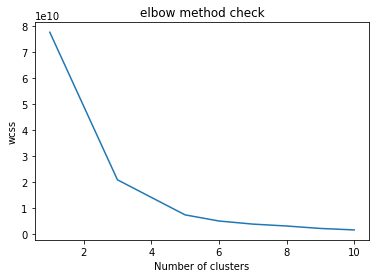

In [16]:
#number of clusters? Using elbow method
def generateElbow(X):
    wcss = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    return wcss
wcss = generateElbow(X)
plt.plot(range(1,11), wcss)
plt.title('elbow method check')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()
#According with the result the recommended amount of clusters is 4.

In [17]:
#applying clusters with 4.
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)

In [18]:
y_kmeans

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [19]:
#Overall clustered dataset
overallClusters = pd.concat([data_original,catDf['Categorie'],pd.DataFrame({'OverallClusters':y_kmeans})], axis=1)
overallClusters.to_csv('overallClusters.csv')

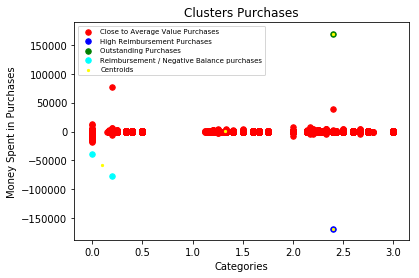

In [30]:
#visualizing the reuslts
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 30, c = 'red', label = 'Close to Average Value Purchases')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 30, c = 'blue', label = 'High Reimbursement Purchases')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 30, c = 'green', label = 'Outstanding Purchases')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 30, c = 'cyan', label = 'Reimbursement / Negative Balance purchases')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=5, c='yellow', label='Centroids')
plt.title('Clusters Purchases')
plt.xlabel('Categories')
plt.ylabel('Money Spent in Purchases')
plt.legend(loc=2, prop={'size': 7})
plt.show()

*According with the artificial intelligence alike weights assign in the natural language processing part, categorie value between 0-1 represent clothes, 1-2 represent personal accessories and 2-3 represent home accessories.

In the above mentioned scatter plot we can appreciate the overall behaviour of purchases. However, "Close to Average purchases (red)" deserve the time to again perform a second clustering technique to zoom in better into the regular purchases business performance. 

In [33]:
averageClusters = overallClusters.query('OverallClusters == 0') 
averageClusters.to_csv('overallClustersV2.csv')